# Time-explicit LCA of an electric vehicle


This notebook shows how to use `bw_timex` with a cradle-to-grave case study of an electric vehicle. The case study is simplified, not meant to reflect the complexity of electric mobility but to demonstrate hot to use `bw_timex`. 

More information on the inner workings of `bw_timex` can be found [here](https://timex.readthedocs.io/en/latest/content/theory.html).

> **Note:** This is the "standalone" version of this notebook with some made up background processes, but there is also a version available that works with ecoinvent and premise databases.

## Case study setup


First, we need to set things up for our case study and prepare some databases. This is normal Brightway stuff.

### Preparing the background databases

Timex expects the user to provide the (prospective) background databases. In here, we make up three different background databases, representing the years 2020, 2030 and 2040. Additionally, there is a foreground database containing our ev-process, as well as a very simple biosphere database.

In [1]:
import bw2data as bd

bd.projects.set_current("electric_vehicle_standalone")

# making sure to start fresh
for db in list(bd.databases):
    del bd.databases[db]

In [2]:
biosphere = bd.Database("biosphere")
biosphere.write(
    {
        ("biosphere", "CO2"): {
            "type": "emission",
            "name": "carbon dioxide",
        },
    }
)

background_2020 = bd.Database("background_2020")
background_2030 = bd.Database("background_2030")
background_2040 = bd.Database("background_2040")

background_2020.write({})
background_2030.write({})
background_2040.write({})

background_databases = [
    background_2020,
    background_2030,
    background_2040,
]

100%|██████████| 1/1 [00:00<?, ?it/s]


Vacuuming database 


In [3]:
# These are made-up values supposed to represent the GWI of different ev components at different points in time.
component_gwis = {
    "glider": (10, 5, 2.5),
    "powertrain": (20, 10, 7.5),
    "battery": (10, 5, 4),
    "electricity": (0.5, 0.25, 0.075),
    "glider_eol": (0.01, 0.0075, 0.005),
    "battery_eol": (1, 0.5, 0.25),
}

node_co2 = biosphere.get("CO2")

for component_name, gwis in component_gwis.items():
    for database, gwi in zip(background_databases, gwis):
        database.new_node(component_name, name=component_name, location="somewhere").save()
        component = database.get(component_name)
        component["reference product"] = component_name        
        component.save()
        component.new_edge(input=component, amount=1, type="production").save()
        component.new_edge(input=node_co2, amount=gwi, type="biosphere").save()       
    
    

### Creating the foreground process

Let's create a new foreground database to store the EV process:

In [4]:
foreground = bd.Database("foreground")
foreground.write({})

In [5]:
foreground.new_node("EV_lifecycle", name="Electric vehicle, lifecycle").save()
ev_lifecycle = foreground.get("EV_lifecycle")
ev_lifecycle.new_edge(input=ev_lifecycle, amount=1, type="production").save() # production exchange

Here are some parameter assumptions for the EV:

In [6]:
ELECTRICITY_CONSUMPTION = 0.2  # kWh/km
MILEAGE = 150_000  # km
LIFETIME = 16  # years

# Overall mass: 1200 kg
MASS_GLIDER = 840  # kg
MASS_POWERTRAIN = 80  # kg
MASS_BATTERY = 280  # kg

Getting the input processes of the EV from the 2020 background database:

In [7]:
glider_production = background_2020.get("glider")
powertrain_production = background_2020.get("powertrain")
battery_production = background_2020.get("battery")
electricity_production = background_2020.get("electricity")
glider_eol = background_2020.get("glider_eol")
battery_eol = background_2020.get("battery_eol")

Now we can create the exchanges:


In [8]:
glider_production_exchange = ev_lifecycle.new_edge(
    input=glider_production, 
    amount=MASS_GLIDER, 
    type="technosphere"
)

powertrain_production_exchange = ev_lifecycle.new_edge(
    input=powertrain_production, 
    amount=MASS_POWERTRAIN, 
    type="technosphere"
)

battery_production_exchange = ev_lifecycle.new_edge(
    input=battery_production, 
    amount=MASS_BATTERY, 
    type="technosphere"
)

electricity_production_exchange = ev_lifecycle.new_edge(
    input=electricity_production,
    amount=ELECTRICITY_CONSUMPTION * MILEAGE,
    type="technosphere",
)

glider_eol_exchange = ev_lifecycle.new_edge(
    input=glider_eol,
    amount=MASS_GLIDER,
    type="technosphere",
)

battery_eol_exchange = ev_lifecycle.new_edge(
    input=battery_eol, 
    amount=MASS_BATTERY, 
    type="technosphere"
)

We need to add the temporal distributions at the exchanges level. 
See [bw_temporalis documentation](https://github.com/brightway-lca/bw_temporalis) for more information on `TemporalDistribution`. Timedelta, which we use below, describes relative temporal relations, e.g. 2 years earlier. 


In [9]:
from bw_temporalis import TemporalDistribution, easy_timedelta_distribution
import numpy as np

In [10]:
td_production = easy_timedelta_distribution(
    start=-4,
    end=0,
    resolution="Y",     # "Y": "Years", "M": "Months", "D": "Days", "h": "Hours" etc.
    steps=5,
    kind="triangular", # available kinds: "triangular", "uniform", "normal"
    param=-1,
)

td_use_phase = easy_timedelta_distribution(
    start=0,  # (inclusive)
    end=LIFETIME,  # (inclusive)
    resolution="Y",
    steps=(LIFETIME + 1),  # Includes both start and end
    kind="uniform",  
)

td_eol = TemporalDistribution(
    date=np.array([LIFETIME + 1], dtype="timedelta64[Y]"), amount=np.array([1])  # if you build a TD manually, make sure that length of date array == length of amount array, and the sum of elements in the amount array == 1
)

Let's explore what a `TemporalDistribution` looks like:

In [11]:
print("td_production.date [s]:  ", td_production.date)
print("td_production.amount [-]:", td_production.amount)
type(td_production)

td_production.date [s]:   [-126227808  -94670856  -63113904  -31556952          0]
td_production.amount [-]: [0.         0.16666667 0.33333333 0.5        0.        ]


bw_temporalis.temporal_distribution.TemporalDistribution

We now add the temporal information to the inputs of our EV. We add temporal distributions to all exchanges, but you don't have to.


In [12]:
glider_production_exchange["temporal_distribution"] = td_production
glider_production_exchange.save()

powertrain_production_exchange["temporal_distribution"] = td_production
powertrain_production_exchange.save()

battery_production_exchange["temporal_distribution"] = td_production
battery_production_exchange.save()

electricity_production_exchange["temporal_distribution"] = td_use_phase
electricity_production_exchange.save()

glider_eol_exchange["temporal_distribution"] = td_eol
glider_eol_exchange.save()

battery_eol_exchange["temporal_distribution"] = td_eol
battery_eol_exchange.save()

### Add a characterization method

Finally, we need some characterization method. Again, this is just a simple made-up one:

In [13]:
bd.Method(("GWP", "example")).write(
    [
        (("biosphere", "CO2"), 1),
    ]
)

## LCA using `bw_timex`


Now that the data is set up, we can get startet with the actual time-explicit LCA. As usual, we need to select a method first:

In [14]:
method = ("GWP", "example")

`bw_timex` needs to know the representative time of the databases:

In [15]:
from datetime import datetime

database_date_dict = {
    background_2020.name: datetime.strptime("2020", "%Y"),
    background_2030.name: datetime.strptime("2030", "%Y"),
    background_2040.name: datetime.strptime("2040", "%Y"),
    "foreground": "dynamic",  # flag databases that should be temporally distributed with "dynamic"
}

Now, we can instantiate a `TimexLCA`. It has a similar structure as `bw2calc.LCA`, but with the additional argument `database_date_dict`.

Not sure about the required inputs? Check the documentation using `?`

In [16]:
from bw_timex import TimexLCA
TimexLCA?

Init signature: TimexLCA(demand: dict, method: tuple, database_date_dict: dict = None) -> None
Docstring:     
Class to perform time-explicit LCA calculations.

A TimexLCA retrieves the LCI of processes occuring at explicit points in time and relinks their technosphere
exchanges to match the technology landscape at that point in time, while keeping track of the timing of the
resulting emissions. As such, it combines prospective and dynamic LCA approaches.

TimexLCA first calculates a static LCA, which informs a priority-first graph traversal. From the graph traversal,
temporal relationships between exchanges and processes are derived. Based on the timing of the processes, bw_timex
matches the processes at the intersection between foreground and background to the best available background
databases. This temporal relinking is achieved by using datapackages to add new time-specific processes. The new
processes and their exchanges to other technosphere processes or biosphere flows extent 

Let's create a `TimexLCA` object for our EV life cycle:

In [17]:
tlca = TimexLCA({ev_lifecycle.key: 1}, method, database_date_dict)

Next, we build a timeline of the exchanges. To do this, we can call the `build_timeline()` method, which does the graph traversal and creates a timeline dataframe from the results. The exchanges (rows of the dataframe) are aggregated to the resolution specified in the argument `temporal_grouping`. There are also many more options to specify the timeline creation and graph traversal process. Here are the most important ones:
- `temporal_grouping`: temporal resolution to which processes will be aggregated,"year" (default), "month", "day" or "hour"
- `interpolation_type`: How the best fitting background database is selected: "linear"(default), "closest"
- `edge_filter_function`: Custom filter function specifying when to stop the graph traversal.
- `cutoff`: stops graph traversal for nodes below this contribution to the static impact score.
- `max_calc`: stops graph traversal if this number of nodes has been traversed

For all these options, we provide sensible default values. Of course you can always just check the docstrings to see all your options and our assumptions for default values. 

So, let's build the timeline:


In [18]:
tlca.build_timeline()

Starting graph traversal
Calculation count: 6


c:\Users\Layton_PC\Desktop\MA\Repo\optimex\venv\Lib\site-packages\bw_timex\timex_lca.py:195: UserWarning: No edge filter function provided. Skipping all edges within background databases.
  warnings.warn(
c:\Users\Layton_PC\Desktop\MA\Repo\optimex\venv\Lib\site-packages\bw_timex\timeline_builder.py:482: Warning: Reference date 2041-01-01 00:00:00 is higher than all provided dates. Data will be taken from the closest lower year.
  warnings.warn(


,date_producer,producer_name,date_consumer,consumer_name,amount,interpolation_weights
0,2021-01-01,glider,2024-01-01,"Electric vehicle, lifecycle",140.0,"{'background_2020': 0.8998083766767041, 'backg..."
1,2021-01-01,powertrain,2024-01-01,"Electric vehicle, lifecycle",13.333333,"{'background_2020': 0.8998083766767041, 'backg..."
2,2021-01-01,battery,2024-01-01,"Electric vehicle, lifecycle",46.666667,"{'background_2020': 0.8998083766767041, 'backg..."
3,2022-01-01,glider,2024-01-01,"Electric vehicle, lifecycle",280.0,"{'background_2020': 0.7998905009581166, 'backg..."
4,2022-01-01,powertrain,2024-01-01,"Electric vehicle, lifecycle",26.666667,"{'background_2020': 0.7998905009581166, 'backg..."
5,2022-01-01,battery,2024-01-01,"Electric vehicle, lifecycle",93.333333,"{'background_2020': 0.7998905009581166, 'backg..."
6,2023-01-01,glider,2024-01-01,"Electric vehicle, lifecycle",420.0,"{'background_2020': 0.6999726252395291, 'backg..."
7,2023-01-01,powertrain,2024-01-01,"Electric vehicle, lifecycle",40.0,"{'background_2020': 0.6999726252395291, 'backg..."
8,2023-01-01,battery,2024-01-01,"Electric vehicle, lifecycle",140.0,"{'background_2020': 0.6999726252395291, 'backg..."
9,2024-01-01,electricity,2024-01-01,"Electric vehicle, lifecycle",1764.705882,"{'background_2020': 0.6000547495209416, 'backg..."


The interpolation weights in the timeline (right most column above) specify the share of the amount of an exchange to be sourced from the respective database. 
`None` means that the exchange is in the foreground supply chain, and not at the intersection with the background system.  

Next, we calculate the time-explicit LCI. The `TimexLCA.lci()` function takes care of all the relinking, based on the information from the timeline. 

In [19]:
tlca.lci()

c:\Users\Layton_PC\Desktop\MA\Repo\optimex\venv\Lib\site-packages\scipy\sparse\linalg\_dsolve\linsolve.py:603: SparseEfficiencyWarning: splu converted its input to CSC format
  return splu(A).solve


If we are only interested in the new overall time-explicit scores and don't care about the timing of the emissions, we can set `build_dynamic_biosphere=False` (default is `True`), which saves time and memory. In that case, you only get the `TimexLCA.inventory`, but not the `TimexLCA.dynamic_inventory`.

In case the timing of emissions is not important, one can directly calculate the LCIA the "standard way" using static characterization methods. Per default, the following calculates the static lcia score based on the impact method chosen in the very beginning:

In [20]:
tlca.static_lcia()
tlca.score   #kg CO2-eq

18108.161482418607

## Dynamic Characterization
In addition to the standard static characterization, the time-explicit, dynamic inventory generated by a `TimexLCA` allows for dynamic characterization. Users can provide their own dynamic characterization functions and link them to corresponding biosphere flows (see example on [dynamic characterization](https://github.com/TimoDiepers/timex/blob/main/notebooks/example_simple_dynamic_characterization.ipynb)), or use the ones we provide out of the box. 

We provide two different metrics for dynamic LCIA of Climate Change: Radiative forcing [W/m2] and Global Warming Potential (GWP) [kg CO2-eq]. For both of these metrics, we have parameterized dynamic characterization functions for all GHG's that [IPCC AR6](https://www.ipcc.ch/report/ar6/wg1/chapter/chapter-7/) provides data for.

For the dynamic characterization, users can also choose the length of the considered time horizon (`time_horizon`) and whether it is a fixed time horizon (`fixed_time_horizon`). Fixed means that the time horizon for all emissions (no matter when they occur) starts counting at the time of the functional unit, resulting in shorter time horizons for emissions occuring later. If the time horizon is not fixed (this is what conventional impact assessment factors assume), it starts counting from the timing of the emission.


### Radiative forcing


First, let's import a dynamic characterization function for CO2

In [21]:
from dynamic_characterization.timex.radiative_forcing import characterize_co2

Then, we can create the characterization_function_dict where we map the function to the corresponding flow via its ID:

In [22]:
characterization_function_dict = {
    bd.get_node(code="CO2").id: characterize_co2,
}

Now we can do the actual dynamic characterization:

In [23]:
tlca.dynamic_lcia(metric="radiative_forcing", fixed_time_horizon=True, characterization_function_dict=characterization_function_dict)

,date,amount,flow,activity
0,2022-01-01 05:49:12,2.190558e-12,1,21
1,2022-01-01 05:49:12,4.172492e-13,1,22
2,2022-01-01 05:49:12,7.301861e-13,1,23
3,2023-01-01 05:49:12,1.383566e-12,1,26
4,2023-01-01 05:49:12,7.906091e-13,1,25
...,...,...,...,...
2643,2124-01-02 00:54:00,3.432123e-13,1,36
2644,2124-01-02 01:37:12,2.490127e-13,1,40
2645,2124-01-02 02:20:24,1.624833e-13,1,44
2646,2124-01-02 03:03:36,5.114609e-14,1,49


The method call returns a dataframe of all the individual emissions at their respective timesteps, but we can also just look at the overall score:

In [24]:
tlca.dynamic_score #W/m2 (radiative forcing)

1.6009938649688348e-09

To visualize the results, we provide a simple plotting functions:

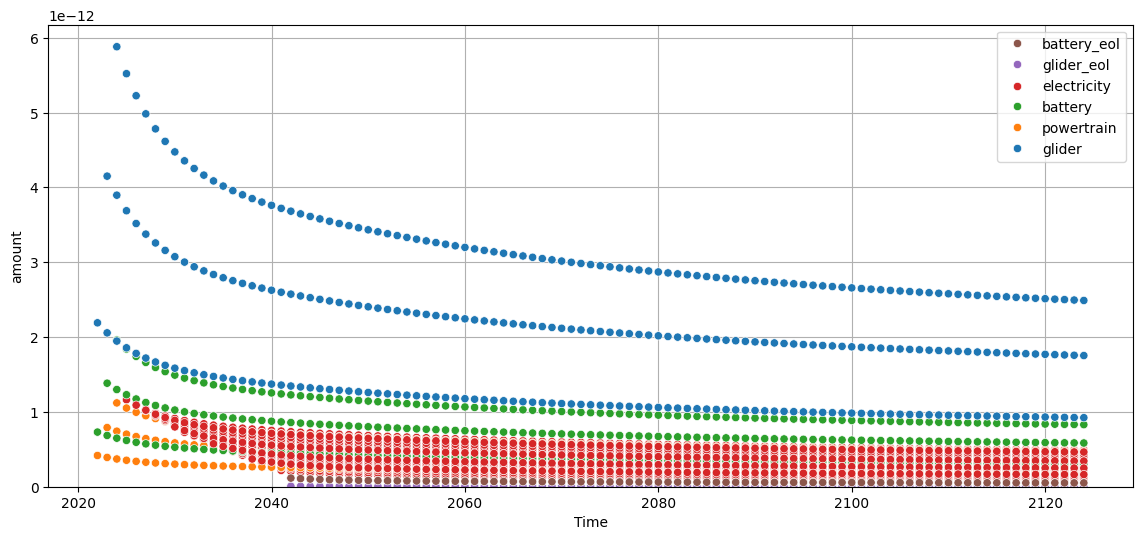

In [25]:
tlca.plot_dynamic_characterized_inventory(sum_emissions_within_activity=True)

Without summing up the emissions within the activity, one can see that there are also negative emissions in the system, which stem from the premise-induced BECCS in the future electricity production:

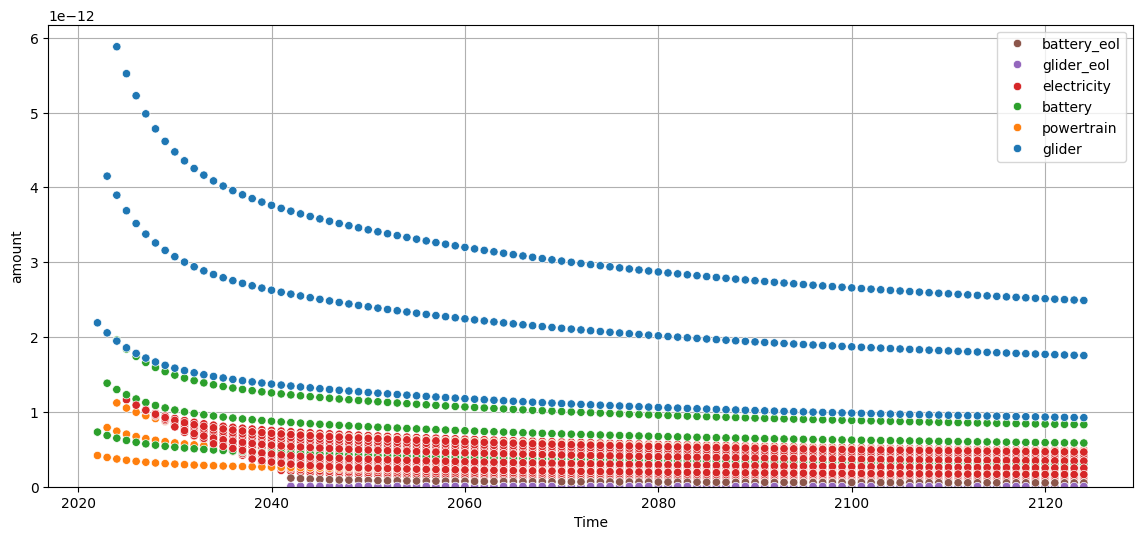

In [26]:
tlca.plot_dynamic_characterized_inventory()  

There is also a flag to plot the cumulative radiative forcing:

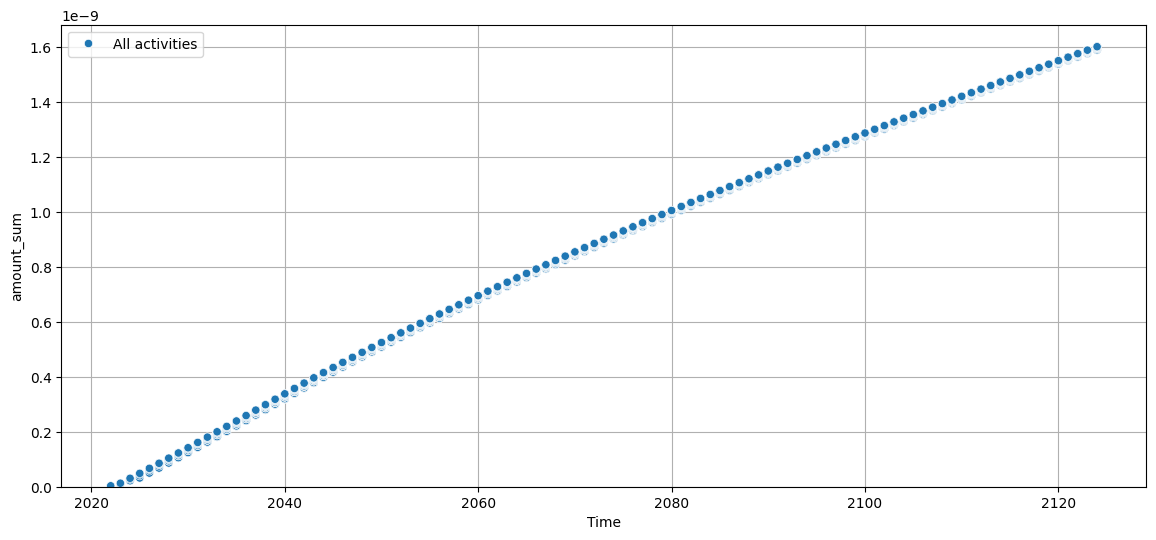

In [27]:
tlca.plot_dynamic_characterized_inventory(sum_activities= True, cumsum=True)

### GWP


Similar options are available for the metric GWP, which compares the radiative forcing of a GHG to that of CO2 over a certain time horizon (commonly 100 years, but it can be set flexibly in `time_horizon`).

In [28]:
tlca.dynamic_lcia(metric="GWP", fixed_time_horizon=False, time_horizon=70, characterization_function_dict=characterization_function_dict)
tlca.dynamic_score #kg CO2-eq (GWP)

c:\Users\Layton_PC\Desktop\MA\Repo\optimex\venv\Lib\site-packages\dynamic_characterization\dynamic_characterization.py:262: UserWarning: Using bw_timex's default CO2 characterization function for GWP reference.
  warnings.warn(


18108.161482418607

Plotting the GWP results over time:

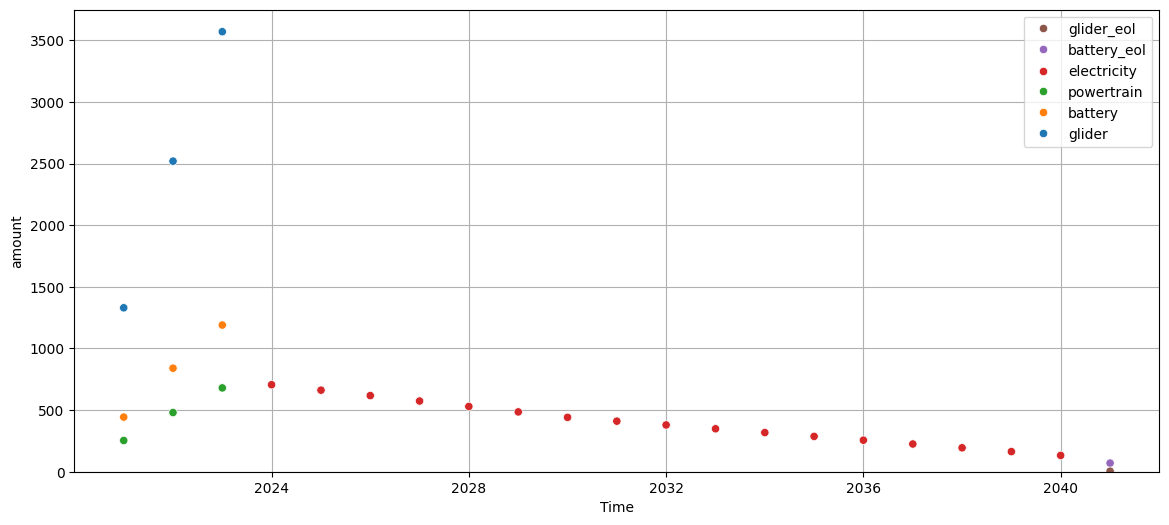

In [29]:
tlca.plot_dynamic_characterized_inventory()

Cumulative:

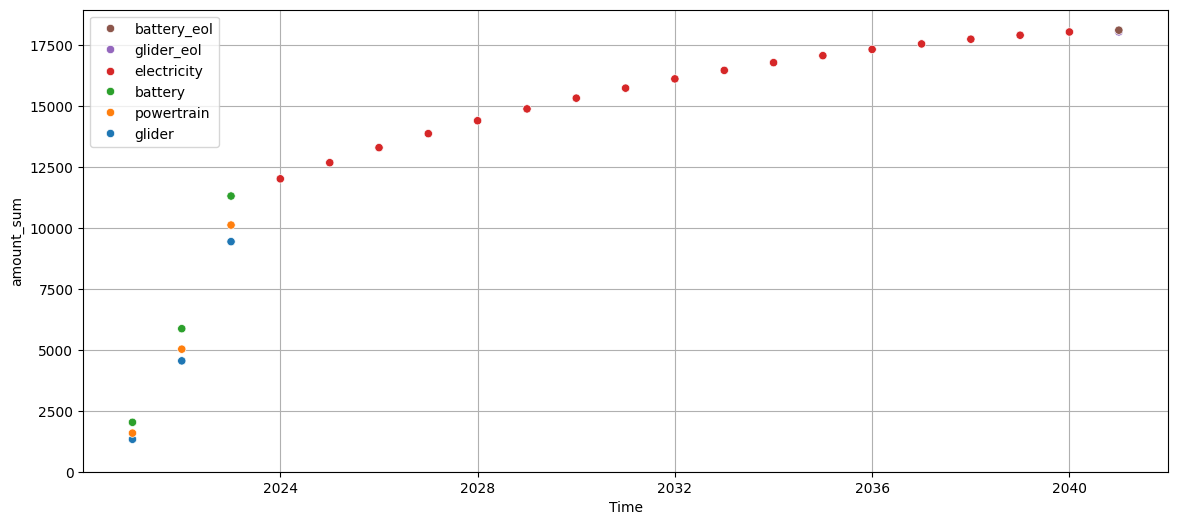

In [30]:
tlca.plot_dynamic_characterized_inventory(sum_emissions_within_activity=True, cumsum=True)

### Comparison of time-explicit results to static results
It's helpful to understand how the time-explicit results differ from those using static assessments. 

We compare the time-explicit results with those of an LCA for the year 2020 and 2040 for the standard GWP100 metric (time horizon=100 and no fixed time horizon). This means we neglect the additional differences of the time-explicit results that would arise from using dynamic LCIA. 

Time-explicit scores:

In [31]:
tlca.dynamic_lcia(metric="GWP", fixed_time_horizon=False, time_horizon=100, characterization_function_dict=characterization_function_dict)
tlca.dynamic_score

c:\Users\Layton_PC\Desktop\MA\Repo\optimex\venv\Lib\site-packages\dynamic_characterization\dynamic_characterization.py:262: UserWarning: Using bw_timex's default CO2 characterization function for GWP reference.
  warnings.warn(


18108.161482418607

The 2020 (static) score has already been calculated by TimexLCA in the beginning, originally to set the priorities for the graph traversal. But we can still access the score:

In [32]:
tlca.static_lca.score

28088.399999812245

However, further down we also want to look at what part of the life cycle has what contribution. To get this info, we need some more calculations:

In [33]:
import bw2calc as bc

static_scores = {}
for e in ev_lifecycle.exchanges():
    if e.input == ev_lifecycle.key:
        continue
    lca = bc.LCA({e.input: e.amount}, method)
    lca.lci() # one could probably do this more efficiently by using .redo_lcia, but who doesn't like a 15s break :)
    lca.lcia()
    static_scores[e.input["name"]] = lca.score

Similarly, we calculate the 2040 (prospective) scores by just changing the database the exchanges point to:

In [34]:
#first create a copy of the system and relink to processes from 2040 database
prospective_ev_lifecycle = ev_lifecycle.copy()

for exc in prospective_ev_lifecycle.exchanges():
    if exc.input == prospective_ev_lifecycle:
        continue
    exc.input = bd.get_node(
        **{
            "database": background_2040.name,
            "name": exc.input["name"],
            "product": exc.input["reference product"],
            "location": exc.input["location"],
        }
    )
    exc.save()

prospective_scores = {}
for e in prospective_ev_lifecycle.exchanges():
    if e.input == prospective_ev_lifecycle.key:
        continue
    lca = bc.LCA({e.input: e.amount}, method)
    lca.lci()
    lca.lcia()
    prospective_scores[e.input["name"]] = lca.score

Lets compare the overall scores:

In [35]:
print("Static score: ", sum(static_scores.values())) # should be the same as tlca.static_lca.score
print("Prospective score: ", sum(prospective_scores.values()))
print("Time-explicit score: ", tlca.dynamic_score)

Static score:  28088.399999812245
Prospective score:  6144.20008931309
Time-explicit score:  18108.161482418607


To better understand what's going on, let's plot the scores as a waterfall chart  based on timing of emission. Also, we can look at the "first-level contributions":

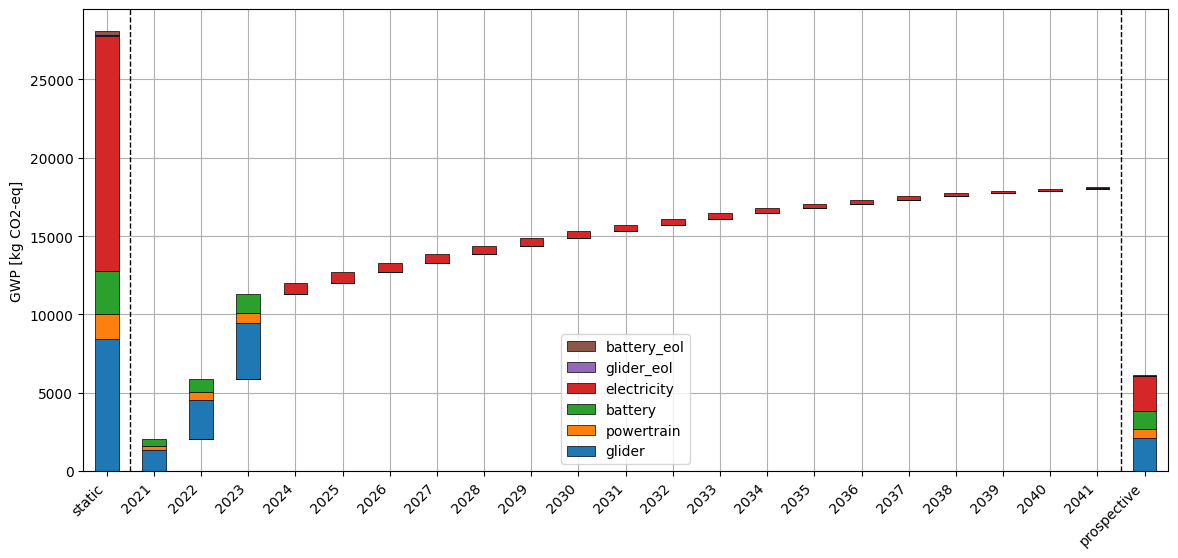

In [36]:
from bw_timex.utils import plot_characterized_inventory_as_waterfall

order_stacked_activities = (
    [  # to sort stacked bars in waterfall plot chronologically from production to EoL
        "glider",
        "powertrain",
        "battery",
        "electricity",
        "glider_eol",
        "battery_eol",
    ]
)

plot_characterized_inventory_as_waterfall(
    tlca,
    static_scores=static_scores,
    prospective_scores=prospective_scores,
    order_stacked_activities=order_stacked_activities,
)

One can see that the time-explicit results (in the middle) are somewhere in between the static and the prospective results. This makes sense as at each timestep, the underlying processes are sourced from progressively "cleaner" background databases, reaching a lower impact than if they are only sourced from the current database, but not so low as the prospective results, which are fully sourced from the most decarbonized database. Notably, the electricity consumption in the use-phase, modelled uniformly over the lifetime of the EV, contributes less and less to the score in the later years, since the electricity becomes cleaner in the future databases.